# 波形に対する各アルゴリズムの特徴

## 概要
波形データに対して以下のアルゴリズムをフィッティングさせたときの挙動から、それぞれの特徴を考察していく。
- todo

## 流れ
以下の手順を繰り返す。
- model.fit(x, y)
- model.predict(x)
- 自分で回帰式を描く。


## 備考
- パラメータチューニングは目視です。サボりました。
- 数式中で、ベクトルもスカラーも同じ字体で書いています。サボりました。添字の有無とかで判断していただけたらと思います。
- 補足説明は偏りがちの個人の解釈です。

# 準備

In [22]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1 MB 12.4 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=26d7682ea2caea0036a1e7c0fd01a122d571855d344ddcd3a075229568680e19
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [23]:
# いつもの事前import
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn

## 人工データの生成

今回使用する人工データは、サインカーブに正規分布に従う乱数をノイズとして加えて生成した。
シード値は関数内で固定しているのでいつも同じ乱数を返す。

数式で表すと、 $\mathcal{N}(\sin(x), (0.5)^2)$ である。

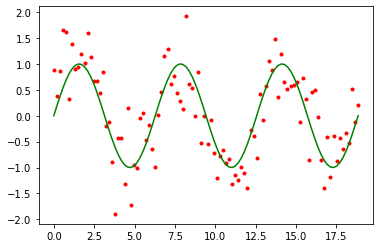

In [2]:
def make_curve(n=100, std=0.5, return_true=False):
    np.random.seed(0)
    x = np.linspace(0, 6*np.pi, n).reshape(-1, 1)
    true = np.sin(x)
    y = true + np.random.normal(scale=0.5, size=[n, 1])
    if return_true:
        return x, y, true
    return x, y

x, y, true = make_curve(return_true=True)
plt.plot(x, true, color="g")
plt.scatter(x, y, marker=".", color="r")

↑真のモデル（緑)と人工データ（赤）の図。

$0 < x < 2.5$ らへんでは、赤点が緑線の上に分布しがちだったり、 $(x, y) = (8, 2)$ らへんに外れ値があったりする。
このようなノイズの影響を受けたデータに対してどのように反応するのかをみると面白い。

## 共通の処理を関数化

In [3]:
def show(x, y, model, pred=None):
    fig, (l, r) = plt.subplots(1, 2, figsize=[15, 4])
    l.scatter(x, y, marker=".", color="r")
    l.plot(x, model.predict(x))
    r.scatter(x, y, marker=".", color="r")
    if pred is not None:
        r.plot(x, pred, color="k")
    return l, r

# Polynominal（多項式回帰）

## 理論編

非線形回帰をするモデルで一番教科書的によく使われるモデル。

　$y(x, w_0, w_1, \dots, w_M) = w_0 + w_1 x + w_2 x^2 + \cdots + w_M x^M$

特徴ベクトルを $\phi(x) = [\phi_0, \phi_1, \phi_2, \dots, \phi_M]^T = [1, x, x^2, \dots, x^M]^T$ と定義すれば、

　$y(x, w) = w_0 \phi_0 + w_1 \phi_1 + w_2 \phi_2 + \cdots + w_M \phi_M = w^T \phi$

と簡単に書ける。この形は、線形基底関数モデルと呼ばれる。

## 実装編

今回のデータは極値（＝カーブの数）が6個なので7次関数で上手く回帰できるだろう。

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4f52dd8c10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4f4e2c9690>)

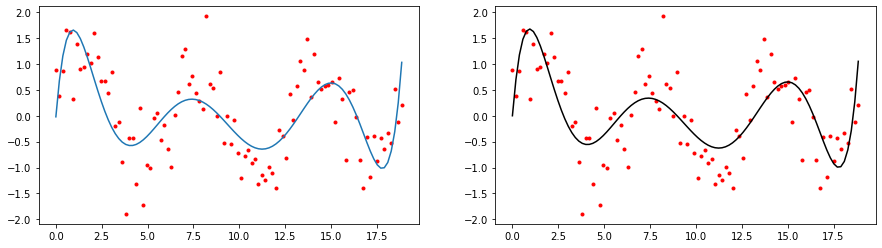

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

trans = PolynomialFeatures(degree=7)
poly = Pipeline([('poly', trans), ('linear', LinearRegression())])

x, y = make_curve()
poly.fit(x, y.ravel())
Phi = trans.fit_transform(x)
W = poly.named_steps['linear'].coef_

show(x, y, model=poly, pred=W @ Phi.T)

両サイドの曲線が急。多項式は $x \to \pm \infty$ のとき発散するので、どうしても外側が強くなりやすいのかもしれない。
正則化でパラメータの値を小さくすれば落ち着きそうだが、Ridgeだと全パラメータの値が平等に小さくなって上手くいってる真ん中部分のバイアスが広がりそうだから、ElasticNetあたりが良いのかな？

# KernelRidge（カーネル法）

## 理論編

勉強不足なので上手く説明できないけど、線形基底関数モデルを別の視点から見たイメージ。


### 双対定理（duality theorem）

主問題と双対問題のいずれか一方が最適解を持つなら、もう一方も最適解を持ち、主問題の最小値と双対問題の最大値は一致する。
https://ja.wikipedia.org/wiki/%E5%8F%8C%E5%AF%BE%E5%95%8F%E9%A1%8C

今回の場合は、
- 主問題: 普通に、線形基底関数モデルのパラメータを最適化しようとすること。
- 双対問題: カーネル法を使ってパラメータを最適化しようとすること。

双対問題を解こうとすると特徴ベクトルは必ず内積の形で出てくることがポイント。
多項式回帰のときと同じく、特徴ベクトルは $\phi(x) = [1, x, x^2, \cdots, x^M]^T$ とする。

特徴ベクトルの内積を計算すると、
$$
\phi(x_i)^T \phi(x_j) = 1 + x_ix_j + x_i^2x_j^2 + \cdots + x_i^Mx_j^M
$$
という多項式が得られる。ただ、下式でも多項式を得ることができる。
$$
k(x_i, x_j) = (x_i^T x_j + c)^M = \sum_{k=0}^{M} \binom{M}{k} (x_i^T x_j)^k c^{M-k}
$$

この式をカーネル関数と呼び、特徴ベクトル $\phi$ の内積を入力ベクトル $x$ の関数で表せることを「カーネルトリック」と呼ぶ。
（カーネルトリックは $x$ が多次元になったときに効果を発揮する。）

難しいので詳細説明は省いてsota君のおすすめ動画を引用しておく。

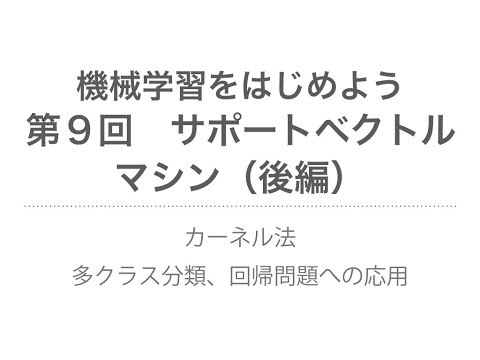

In [5]:
from IPython.display import YouTubeVideo
YouTubeVideo("fUSO6-0o3ds")

## 実装編

カーネル関数 $k(x_i, x^*_j)$ を $(i, j)$ 成分とした行列を $K$ 、パラメータを $w$ とおく。
すると、回帰式は、

　$y(x, w) = Kw$

となる。この回帰式の特徴として以下のようなものがある。

- $K$ の列数はデータ数なので、パラメータもデータの数だけ必要になる。
- 毎回予測するときに学習データが全て必要になる。

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4f4dd7c150>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4f4552c610>)

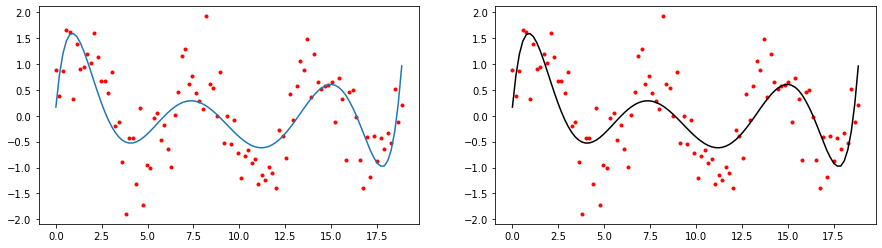

In [6]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import polynomial_kernel

kr = KernelRidge(kernel="poly", degree=7, coef0=x.mean(), alpha=100000)
kr.fit(x, y)
K = polynomial_kernel(x, x, degree=7, coef0=x.mean())

show(x, y, kr, pred=K @ kr.dual_coef_)

線形回帰とめっちゃ似てる。というか理論的に同じになるのかな？  
単回帰だとカーネル法の方が圧倒的に遅かった。この原因は計算量が $O(M^3)$ だったのが $O(N^3)$ になったからかな。

`coef0` を良い感じの値にする必要があった。カーネル関数が
$$
(X + c)^d = X^d + cX^{d-1} + c^2 X^{d-2} + \cdots + c^{d-1} X + c^d
$$
なので、$|x| > 1$のとき累乗するとどうしても高次成分が爆発する。
（同じ式中に、$x=10$ なら $c100^6$ と $c^610$ が一緒に出てくる。）  
なので、低次成分を高次成分に負けないように、定数 $c$ を設定しなければいけないみたい。

# Support Verctor Machine

## 理論編

coming soon...  
暇になったら更新する。このへんからちょっと理論の説明が雑になってる。

学習時の大まかな流れはカーネル法と同じ（だったはず）。
大きな違いが、予測時に使用するデータがカーネル法は全て必要だったが、
SVMの場合は一部のデータだけで良い。
この一部のデータのことをサポートベクターと呼ぶ。
これらは簡単に言うと、扱うのが難しいベクトルの集まりである。

参考: [SVMとKernelRidge法の違いは何でしょうか？ - Quora](https://jp.quora.com/SVM-to-KernelRidge-hou-no-chigai-ha-nande-shou-ka)

## 実装編

回帰式はカーネル法と同じ。ただ、以下のような違いがある。

- パラメータはサポートベクターの数だけで良い。
- 予測時はサポートベクターだけあればいいので、保存容量が減る。

ちなみに、カーネル関数は色んなものがあるし自作することもできる。KernelRidge では多項式回帰との比較のために多項式カーネルを指定したが、
RBFカーネル（Radial Basis Function, 動径基底関数）の方が有名。RBFカーネルの特徴は指数関数をテイラー展開することで

<img src=https://miro.medium.com/max/1750/1*2semMMlw6nrJVhXo78UCLA.png width=800>

暗黙に無限次元の特徴空間で回帰していると見ることができる。

参考: [Understanding the Kernel Trick with fundamentals - towards data science](https://towardsdatascience.com/truly-understanding-the-kernel-trick-1aeb11560769)

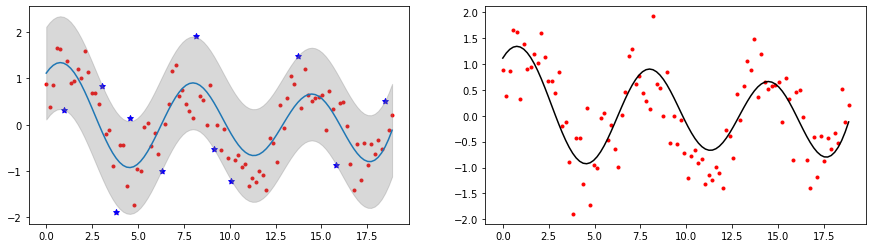

In [7]:
from sklearn.svm import SVR
from sklearn.metrics.pairwise import rbf_kernel

eps = 1
svr = SVR(kernel="rbf", C=1000, epsilon=eps)
x, y = make_curve()
svr.fit(x, y.ravel())

sv = x[svr.support_]
K = rbf_kernel(sv, x, gamma=1 / x.var())
pred = (svr.dual_coef_ @ K) + svr.intercept_
pred = pred.flatten()

l, _ = show(x, y, svr, pred=pred)
l.scatter(x[svr.support_], y[svr.support_], marker="*", color="b")
l.fill_between(x.ravel(), pred-eps, pred+eps, color="gray", alpha=0.3)

青い★のデータがサポートベクター。特殊な誤差関数を用いることで、グレーの領域（`epsilon`で指定した幅）のデータは誤差ゼロをして扱われる。



# Bayes

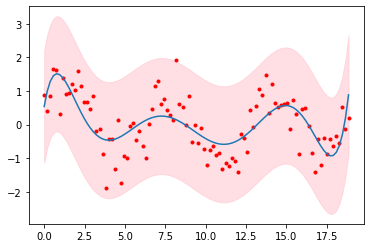

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline

x, y = make_curve()

bayes = Pipeline([('poly', PolynomialFeatures(degree=7)),
                  ('linear', BayesianRidge())])
bayes.fit(x, y.ravel())
ymean, ystd = bayes.predict(x, return_std=True)

plt.fill_between(x.ravel(), ymean - ystd, ymean + ystd, color="pink", alpha=0.5)
plt.plot(x, ymean)
plt.scatter(x, y, marker=".", color="r")

このモデルは確率モデルの一種で、確率モデルの本来の出力は曲線ではなく下図のような確率分布の山脈である。
その頂上の尾根線（最頻値）だけを引いたのが青線だ。なので、確率モデルを使っているのに回帰曲線だけしか使わないのは**とてももったいない**。

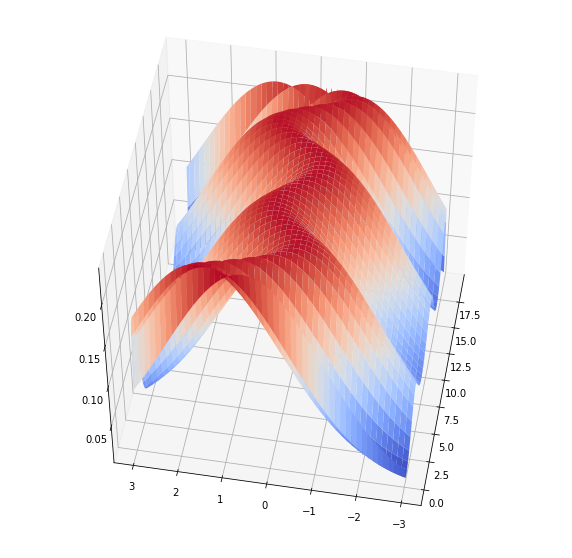

In [9]:
from scipy.stats import norm
XX, YY = np.meshgrid(x, np.linspace(-3, 3, 100))
Z = norm.pdf(x=np.linspace(-3, 3, 100).reshape(-1, 1), loc=ymean, scale=ystd)
fig, ax = plt.subplots(subplot_kw={"projection": '3d'}, figsize=[10, 10])
ax.plot_surface(XX, YY, Z, linewidth=0, cmap="coolwarm")
ax.view_init(elev=50, azim=190)

## ガウス過程

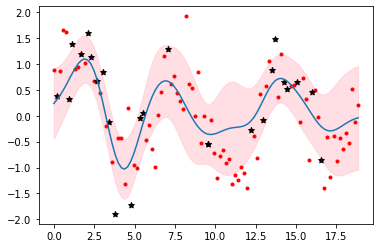

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor

np.random.seed(1)
indices = np.sort(np.random.choice(100, size=25))
x1 = x[indices]
y1 = y[indices]

gp = GaussianProcessRegressor(alpha=1)
gp.fit(x1, y1.ravel())

ymean, ystd = gp.predict(x, return_std=True)

plt.fill_between(x.ravel(), ymean - ystd, ymean + ystd, color="pink", alpha=0.5)
plt.plot(x, ymean)
plt.scatter(x, y, marker=".", color="r")
plt.scatter(x1, y1, marker="*", color="k")

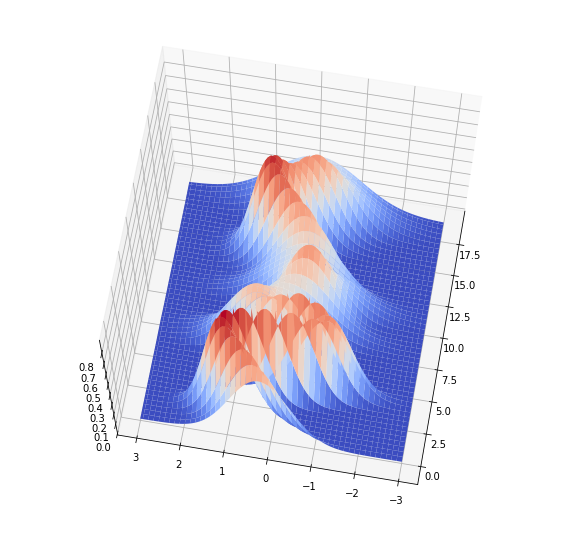

In [11]:
from scipy.stats import norm

XX, YY = np.meshgrid(x, np.linspace(-3, 3, 100))
Z = norm.pdf(x=np.linspace(-3, 3, 100).reshape(-1, 1), loc=ymean, scale=ystd)

fig, ax = plt.subplots(subplot_kw={"projection": '3d'}, figsize=[10, 10])
ax.plot_surface(XX, YY, Z, linewidth=0, cmap="coolwarm")
ax.view_init(elev=70, azim=190)

# NN

## predic関数を自作

In [12]:
def predict(x, model):
    def relu(X):
        return np.maximum(X, 0, out=X)

    act = x.reshape(-1, 1)
    for w, w0 in zip(model.coefs_, model.intercepts_):
        act = relu(act) @ w + w0
        
    return act

## 三層

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4f45007f90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4f3edad3d0>)

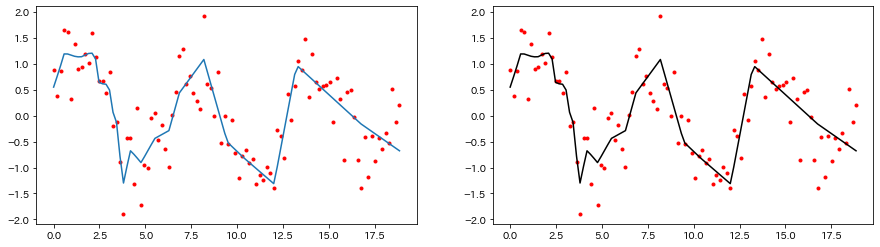

In [27]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(20, 20, 20), alpha=1e-5,
                   solver="lbfgs", max_iter=1000)
mlp.fit(x, y.ravel())

pred = predict(x, mlp)
show(x, y, mlp, pred)

## 二層

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4f3ed41750>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4f3ecaa890>)

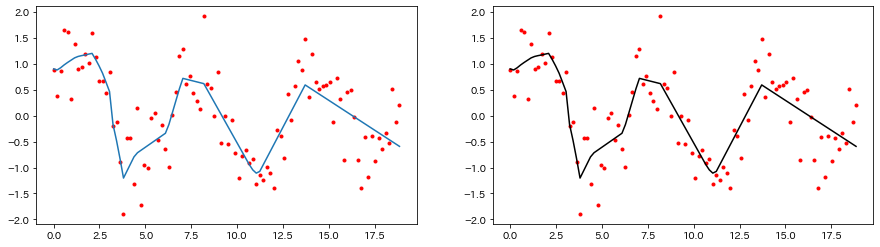

In [28]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(20, 75), alpha=0.05,
                   solver="lbfgs", max_iter=5000)
mlp.fit(x, y.ravel())

pred = predict(x, mlp)
show(x, y, mlp, pred)

## 一層

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4f3fa3a550>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4f3ef774d0>)

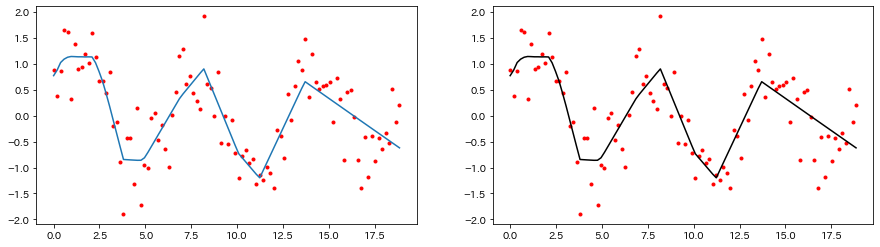

In [29]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(300,), alpha=0.1,
                   solver="lbfgs", max_iter=2000)
mlp.fit(x, y.ravel())

pred = predict(x, mlp)
show(x, y, mlp, pred)

ちょいちょい違いはあるけど大体の特徴は似てる。2行3列のグラフにした方が見やすかったかも。ReLU 関数を活性化関数にした場合は、

？？？「ふん、ニューラルネットワークというのかい。贅沢な名だねぇ。今からお前の名前は**折れ線グラフ**だ。いいかい。**折れ線グラフ**だよ。」

ぱっと見、大したことをやっているわけではない。ただ、過学習しない程度に層やノードを増やせば近似できないものはないとも言える。
次の

# tree

## アンサンブルの可視化用関数を定義

In [16]:
from matplotlib import cm


def show_ensemble(model, cmap=cm.jet, alpha=0.3):
    fig, (l, r) = plt.subplots(1, 2, figsize=[15, 4])
    l.scatter(x, y, marker=".", color="r")
    r.scatter(x, y, marker=".", color="r")
    
    estimators = np.array(model.estimators_).ravel()
    for i, (est, s_pred) in enumerate(zip(estimators, model.staged_predict(x))):
        c = cmap(i/model.n_estimators)
        l.step(x, est.predict(x), alpha=alpha, where="mid", color=c)
        r.step(x, pred, alpha=alpha, where="mid", color=c)

    l.set(title="個々の弱学習木")
    r.set(title="更新中の強学習木")
    return l, r

## 単純な決定木

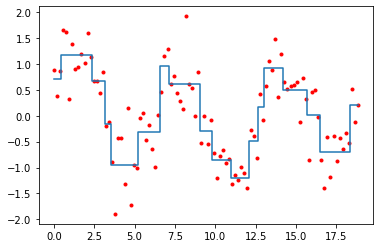

In [17]:
from sklearn.tree import DecisionTreeRegressor

x, y = make_curve()

tree = DecisionTreeRegressor(min_samples_split=11, random_state=0)
tree.fit(x, y.ravel())

plt.step(x, tree.predict(x), where="mid")
plt.scatter(x, y, marker=".", color="r")

## random forest

[Text(0.5, 1.0, '平均した強学習木')]

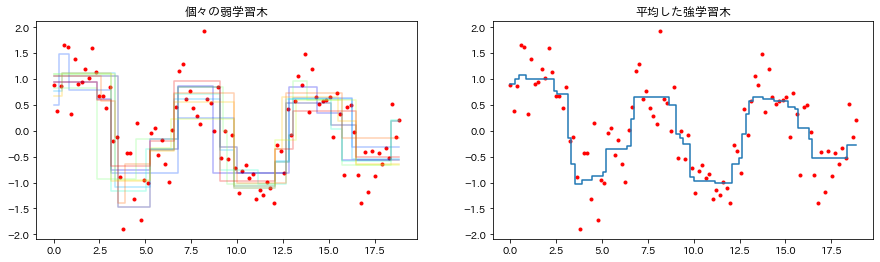

In [24]:
from sklearn.ensemble import RandomForestRegressor
from matplotlib import cm

x, y = make_curve()

rf = RandomForestRegressor(min_samples_split=11, n_estimators=10, random_state=0)
rf.fit(x, y.ravel())


fig, (l, r) = plt.subplots(1, 2, figsize=[15, 4])
l.scatter(x, y, marker=".", color="r")
r.scatter(x, y, marker=".", color="r")

estimators = np.array(rf.estimators_).ravel()
for i, est in enumerate(estimators):
    c = cm.jet(i/rf.n_estimators)
    l.step(x, est.predict(x), alpha=0.3, where="mid", color=c)
r.step(x, rf.predict(x), where="mid")

l.set(title="個々の弱学習木")
r.set(title="平均した強学習木")

## gradient boosting

[Text(0.5, 1.0, '更新中の強学習木')]

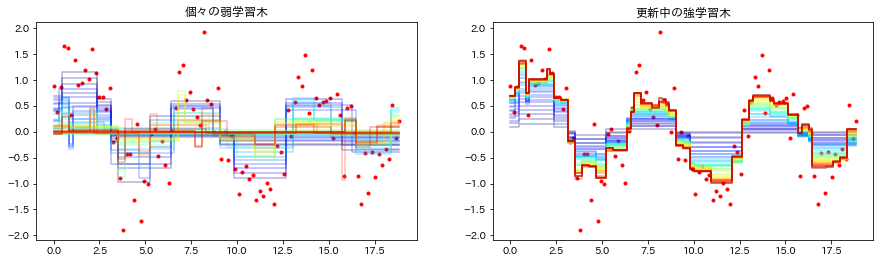

In [25]:
from matplotlib import cm
from sklearn.ensemble import GradientBoostingRegressor

x, y = make_curve()

grad = GradientBoostingRegressor(min_samples_split=11, n_estimators=50, random_state=0)
grad.fit(x, y.ravel())


fig, (l, r) = plt.subplots(1, 2, figsize=[15, 4])
l.scatter(x, y, marker=".", color="r")
r.scatter(x, y, marker=".", color="r")

estimators = np.array(grad.estimators_).ravel()
for i, (est, s_pred) in enumerate(zip(estimators, grad.staged_predict(x))):
    c = cm.jet(i/grad.n_estimators)
    l.step(x, est.predict(x), alpha=0.3, where="mid", color=c)
    r.step(x, s_pred, alpha=0.3, where="mid", color=c)

l.set(title="個々の弱学習木")
r.set(title="更新中の強学習木")

## LightGBM

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


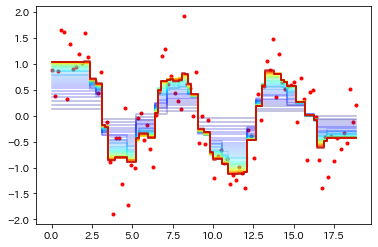

In [26]:
import sklearn.experimental.enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

x, y = make_curve()

hist = HistGradientBoostingRegressor(max_iter=50, min_samples_leaf=10, random_state=0)
hist.fit(x, y.ravel())

for i, pred in enumerate(hist.staged_predict(x)):
    plt.step(x, pred, alpha=0.3, where="mid",
         label=i, color=cm.jet(i/hist.n_iter_)
        )
plt.scatter(x, y, marker=".", color="r")

残念ながらこのモデルは他のものと根本的に実装が異なっていたので、個々のモデルが取得できなかった。

# その他

個々で紹介してないものとして

- K近傍法
  - 得意なこと: 欠損値置換。回帰アルゴリズムの中には、入力変数によっては奇想天外な値を返してしまうことがある。
    ただ、K近傍法は実際に存在する値の平均値を返すので置換処理によって分布が崩れにくいらしい。決定木みたい。
- スプライン回帰
  - スプライン補完という名前の方がよく聞くかもしれない。点と点どうしを繋げてなめらかな曲線を作るときによく使われる。
    デザインツールとかで使われてそう。回帰曲線が全ての点を通るというのが、他のアルゴリズムと違う特徴で、スプライン回帰の目的でもある。